# OOS Predictive Performance of SLOPE

## Outline of the steps in this section:
In here, trading strategy with straddles is looked at

- Note cumulative returns for two trading strategies using S&P500 straddles.
    1) Unconditionally selling S&P500 straddles with a constant maturity of 30 days 
        Calculate the returns slightly different: r_shortStraddle = (straddle_t - straddle_t+1)/(0.2 * SP500_t)
        So I need to interpolate a bit different
        Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
    2) Conditional strategy using SLOPE as an indicator for whether to buy or sell straddles.
        For 1996 - 1999 training period:
        Compute SLOPE_t using PCA on VIX term structure data from beginning of sample to t
        If SLOPE_t in bottom quintile of historical distribution, buy straddles at t, sell at t+1. Otherwise, short at t, buy             back at t+1
        Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
Compare the two strategies, mark in graph where it is different, maybe even a line with the spot price
Play around with the training / test window
What happens when we take another model than PCA?
Exclude Financial crisis? 
Effect Covid?
Own strategy? short 30 day, long 360 day and otherway around? compare sharpe_ratio

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import sqlalchemy as db
import sys
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
from scipy.stats import norm
import math
import matplotlib.dates as mdates

In [91]:
# Import all our data we want to work within this section
#File paths for the CSV files
file_path1 = 'Data/Straddles/short_straddle_returns_correct.csv'
file_path2 = 'Data/Author_Data/STRADDLE_RET.csv'

# Reading the CSV files into Pandas DataFrames
returns_short = pd.read_csv(file_path1)
returns_short['Date'] = pd.to_datetime(returns_short['Date'])

# his given returns include long and short returns (name differ accordingly)
STRADDLE_RET_given = pd.read_csv(file_path2, skiprows=6)
STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'])
STRADDLE_RET_given[STRADDLE_RET_given.columns[1:]] = STRADDLE_RET_given[STRADDLE_RET_given.columns[1:]]/100

## Short variance only
First, we calculate the returns for the full period for the unconditional strategy and produce a graph with these returns.

In [92]:
# Calculate cumulative performance starting from 1 at the first date (1996-01-05)
returns_short['cumulative_performance_1'] = (1 + returns_short['r_v_30']).cumprod()
returns_short['cumulative_performance_2'] = (1 + returns_short['r_v_60']).cumprod()
returns_short['cumulative_performance_3'] = (1 + returns_short['r_v_90']).cumprod()
returns_short['cumulative_performance_6'] = (1 + returns_short['r_v_180']).cumprod()
returns_short['cumulative_performance_9'] = (1 + returns_short['r_v_270']).cumprod()
returns_short['cumulative_performance_12'] = (1 + returns_short['r_v_360']).cumprod()

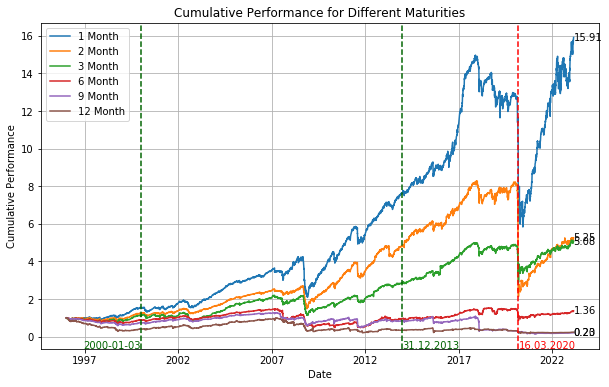

In [93]:
# Plotting the cumulative performances for our data
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]
# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(returns_short['Date'], returns_short[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = returns_short[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2022-01-05', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.axvline(pd.to_datetime('2013-12-31'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2013-12-31'), plt.gca().get_ylim()[0], '31.12.2013', color='darkgreen', ha='left')
plt.axvline(pd.to_datetime('2000-01-03'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2000-01-03'), plt.gca().get_ylim()[0], '2000-01-03', color='darkgreen', ha='right')
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
plt.show()

We do the exact same with his given data to compare it.

In [94]:
# same for his data
STRADDLE_RET_given['cumulative_performance_1'] = (1 + STRADDLE_RET_given['r_1^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_2'] = (1 + STRADDLE_RET_given['r_2^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_3'] = (1 + STRADDLE_RET_given['r_3^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_6'] = (1 + STRADDLE_RET_given['r_6^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_9'] = (1 + STRADDLE_RET_given['r_9^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_12'] = (1 + STRADDLE_RET_given['r_12^{short straddle}']).cumprod()

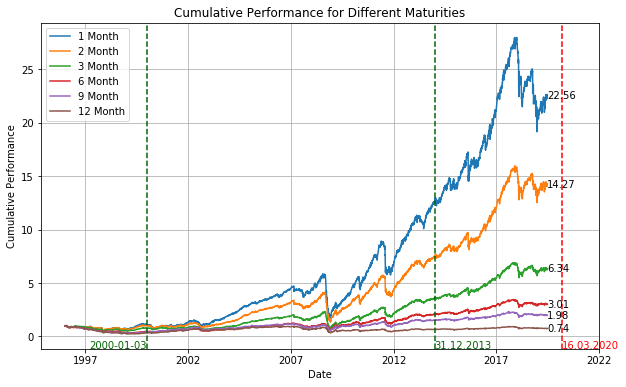

In [95]:
# Plotting the cumulative performances for his data
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]

# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(STRADDLE_RET_given['Date'], STRADDLE_RET_given[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = STRADDLE_RET_given[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(STRADDLE_RET_given['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2022-01-05', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.axvline(pd.to_datetime('2013-12-31'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2013-12-31'), plt.gca().get_ylim()[0], '31.12.2013', color='darkgreen', ha='left')
plt.axvline(pd.to_datetime('2000-01-03'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2000-01-03'), plt.gca().get_ylim()[0], '2000-01-03', color='darkgreen', ha='right')
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities with the given data')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
plt.show()
#his dataset is only until 2019

One can clearly see that we are unfortunately need able to replicate his data 1:1. The characteristics, however, look to be the same.
Again, in the paper, the performance graph start at the beginning of 2000 and only leads to end 2013. See the period in darkgreen. To actually compare it though, one would need to recalculate the full performance to start at 1 in the beginning of 2000.

# Now to the conditional performance of the strategy
Conditional strategy using SLOPE as an indicator for whether to buy or sell straddles.
For 1996 - 1999 training period:
Compute SLOPE_t using PCA on VIX term structure data from beginning of sample to t
If SLOPE_t in bottom quintile of historical distribution, buy straddles at t, sell at t+1. Otherwise, short at t, buy             back at t+1. Watch out for the look ahead bias!!!
Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
The paper uses a training (in-sample) and testperiod (out-of-sample) for the conditional strategy, and the graph is just from beginning of 2000 to 2013 (even though data would have been available up until 2019).

In this next session, I am only working with the 30 day data. The codes can however just be reused for other maturities

In [210]:
# File paths for the PCA slope data
file_path = 'Data/PCA_custom.csv' #our PCA data
file_path1 = 'Data/Author_Data/PCA.csv' #given PCA data

# Reading the CSV files into Pandas DataFrames and only store the column that is needed for the conditional strategy (Slope)
SLOPE = pd.read_csv(file_path)
SLOPE['Date'] = pd.to_datetime(SLOPE['Date'])

SLOPE_given = pd.read_csv(file_path1,skiprows=12)
SLOPE_given['Date'] = pd.to_datetime(SLOPE_given['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

In [211]:
# Import the returns from the long straddle return
# File paths for the CSV files
file_path2 = 'Data/Straddles/straddle_returns_correct.csv'

# Reading the CSV files into Pandas DataFrames
returns_long = pd.read_csv(file_path2)
returns_long = returns_long.rename(columns={'date': 'Date'})
returns_long['Date'] = pd.to_datetime(returns_long['Date'])


## Option1: Expanding window
Here in the first approach, we compute the quintile based on the historical distribution from expanding the window day-to-day.
We compute the signal based on the condition: True = take the long return (as the current SLOPE value is in the bottom quintile), False = take the short return (as the current SLOPE value is not in the bottom quintile).

In [212]:
# Here, the actual signal is computed
# I get the signal from continously comparing the current value of slope to the historical distribution UP TO t. 
# So in my opinion, there is no need to split up the dataset into training and test data.

# Initialize a list to hold the boolean values for each row
in_bottom_quintile = []

# Calculate quantile based on historical data up until date 't' for each observation
for i in range(len(SLOPE)):
    # Select the data up to the current row's date
    slope_data = SLOPE.loc[SLOPE['Date'] <= SLOPE.iloc[i]['Date']]
    #print(len(slope_data))
    current_value = slope_data.iloc[-1]['Slope']
    #print("Current value: ", current_value)
    historical_values = slope_data.iloc[:-2]['Slope']
    #print("Historical values: ", historical_values)
    quantile = historical_values.quantile(0.2)
    #print('Quantile: ', quantile)
    in_bottom_quintile.append(current_value <= quantile)
     #print(f"True/False_{i}: ", in_bottom_quintile)

# Assign the list to a new column 'InBottomQuintile'
SLOPE['InBottomQuintile'] = in_bottom_quintile

In [213]:
# check how many times the current value is in the bottom quintile
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = SLOPE['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.903877
True     0.096123
Name: InBottomQuintile, dtype: float64


In [216]:
#merge the datasets
returns_long_short_30 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30 = returns_long_short_30.merge(SLOPE[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30['InBottomQuintile'] = returns_long_short_30['InBottomQuintile'].shift(1)
returns_long_short_30['InBottomQuintile'][0] = False #set first value manually

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [217]:
# Condition: If the 'InBottomQuintile' is True, use 'return_30' (long return), otherwise 'r_v_30' (short return)
condition = returns_long_short_30.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)

# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30['cumulative_returns'] = cumulative_return
returns_long_short_30 # check the result

Date  return_30    r_v_30 InBottomQuintile  cumulative_returns
0    1996-01-05  -0.047362  0.002855            False            1.002855
1    1996-01-08  -0.050125  0.003020            False            1.005883
2    1996-01-09   0.352578 -0.020640            False            0.985122
3    1996-01-10   0.120899 -0.008543             True            1.104222
4    1996-01-11  -0.096908  0.007298             True            0.997215
...         ...        ...       ...              ...                 ...
6825 2023-02-21   0.074649 -0.007389            False           13.543230
6826 2023-02-22  -0.046649  0.005773            False           13.621416
6827 2023-02-23  -0.043014  0.005049            False           13.690195
6828 2023-02-24  -0.000871  0.000285            False           13.694091
6829 2023-02-27  -0.052136  0.005769            False           13.773087

[6830 rows x 5 columns]

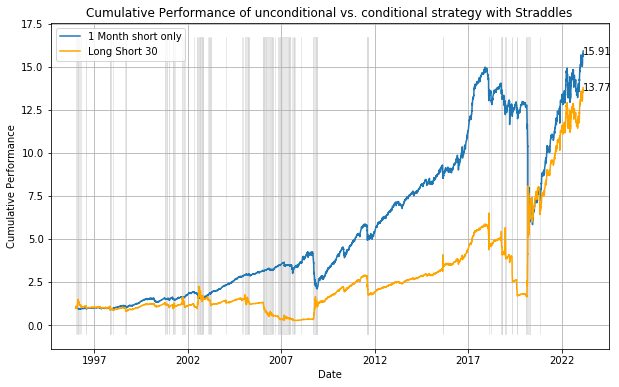

In [218]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))

# Plot the cumulative distribution for the unconditional short straddle strategy as a benchmark
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the cumulative returns from the conditional strategy
plt.plot(returns_long_short_30['Date'], returns_long_short_30['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True, so where the two strategies differ
plt.fill_between(returns_long_short_30['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], 
                 where=returns_long_short_30['InBottomQuintile'], color='lightgrey', alpha=0.5)

#some formatting
years = pd.date_range(start='1996-01-05', end='2023-02-27', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional strategy with Straddles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

This actually does not look comparable to the results he gets.
This needs to be further investigated.
A first idea is to not use the bottom quintile, but compute it with a grid, going from the 0.05 quantile to the 0.2 quantile.

## Try different quantiles
It looks like the strategy with the bottom quintile as the condition is long too often. An idea is the lower this condition so a lower value is taken.

In [220]:
# copy the SLOPE dataset
SLOPE1 = SLOPE.copy()
SLOPE1 = SLOPE1.drop(columns='InBottomQuintile') #delete the InBottomQuantile column
# Quantiles to calculate
quantiles = [0.05, 0.1, 0.15, 0.2]

# Loop through quantiles
for q in quantiles:
    # Initialize a list to hold the boolean values for each row for the current quantile
    in_bottom_quantile = []

    # Calculate quantile based on historical data up until date 't' for each observation
    for i in range(len(SLOPE1)):
        # Select the data up to the current row's date
        slope_data = SLOPE1.loc[SLOPE1['Date'] <= SLOPE1.iloc[i]['Date']]
        current_value = slope_data.iloc[-1]['Slope']
        historical_values = slope_data.iloc[:-2]['Slope']
        quantile_value = historical_values.quantile(q)
        in_bottom_quantile.append(current_value <= quantile_value)
        
    # Assign the list to a new column with a descriptive name
    SLOPE1[f'InBottomQuantile_{q}'] = in_bottom_quantile
# Display the modified DataFrame
print(SLOPE1) # check the results

           Date     Slope  InBottomQuantile_0.05  InBottomQuantile_0.1  \
0    1996-01-04 -1.045535                  False                 False   
1    1996-01-05 -0.985268                  False                 False   
2    1996-01-08 -1.009860                  False                 False   
3    1996-01-09 -1.187096                   True                  True   
4    1996-01-10 -1.159396                   True                  True   
...         ...       ...                    ...                   ...   
6830 2023-02-22 -0.133776                  False                 False   
6831 2023-02-23 -0.106842                  False                 False   
6832 2023-02-24 -0.077891                  False                 False   
6833 2023-02-27 -0.105548                  False                 False   
6834 2023-02-28 -0.126904                  False                 False   

      InBottomQuantile_0.15  InBottomQuantile_0.2  
0                     False                 False  
1      

In [221]:
# get some statistics to see the difference!
# check how many times the current value is in the bottom quintile
print("    Share of short (false) and long (true) for the 0.05-quantile")
value_counts = SLOPE1[f'InBottomQuantile_{0.05}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.1-quantile")
value_counts = SLOPE1[f'InBottomQuantile_{0.1}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.15-quantile")
value_counts = SLOPE1[f'InBottomQuantile_{0.15}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.2-quantile")
value_counts = SLOPE1[f'InBottomQuantile_{0.2}'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the 0.05-quantile
False    0.96752
True     0.03248
Name: InBottomQuantile_0.05, dtype: float64
    Share of short (false) and long (true) for the 0.1-quantile
False    0.950402
True     0.049598
Name: InBottomQuantile_0.1, dtype: float64
    Share of short (false) and long (true) for the 0.15-quantile
False    0.925823
True     0.074177
Name: InBottomQuantile_0.15, dtype: float64
    Share of short (false) and long (true) for the 0.2-quantile
False    0.903877
True     0.096123
Name: InBottomQuantile_0.2, dtype: float64


In [222]:
#merge the datasets
returns_long_short_30_1 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30_1 = returns_long_short_30_1.merge(SLOPE1[['Date', 'InBottomQuantile_0.05',
                                                          'InBottomQuantile_0.1', 'InBottomQuantile_0.15',
                                                          'InBottomQuantile_0.2']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_1[['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']] = returns_long_short_30_1[['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']].shift(1)
returns_long_short_30_1.loc[0, ['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']] = False

In [223]:
quantiles = ['0.05', '0.1', '0.15', '0.2']

for quantile in quantiles:
    condition_col = f'InBottomQuantile_{quantile}'
    return_long = f'return_30'
    return_short = f'r_v_30'

    # Condition: If the current quantile column is True, use the 'return_30' (long return) column, otherwise 'r_v_30' (short return)
    condition = returns_long_short_30_1.apply(lambda row: row[return_long] if row[condition_col] else row[return_short], axis=1)

    # Calculate cumulative returns based on the condition
    cumulative_return = (1 + condition).cumprod()
    returns_long_short_30_1[f'cumulative_returns_{quantile}'] = cumulative_return

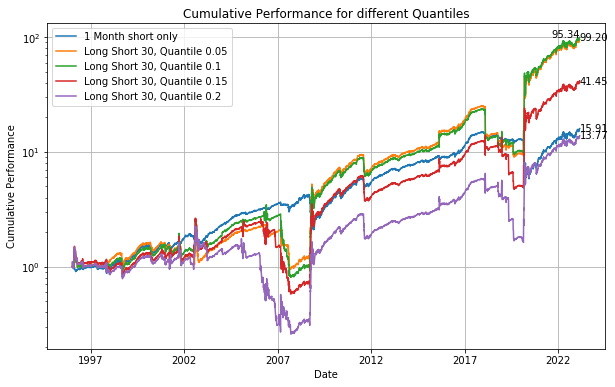

In [224]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))
# Plot the short only cumulative performance
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Plot line for different quantiles
quantiles = ['0.05', '0.1', '0.15', '0.2']
for quantile in quantiles:
    cumulative_col = f'cumulative_returns_{quantile}'
    plt.plot(returns_long_short_30_1['Date'], returns_long_short_30_1[cumulative_col], label=f'Long Short 30, Quantile {quantile}')

    # Add text annotations for the end value of each line
    end_value = returns_long_short_30_1[cumulative_col].iloc[-1]
    if quantile == '0.05':
        plt.text(returns_long_short_30_1['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='bottom', ha='right')
    else:
        plt.text(returns_long_short_30_1['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2023-02-27', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance for different Quantiles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.grid(True)

# Show the modified plot
plt.show()

For fun: check at which quantile the maximum performance would be reached.

In [231]:
# Assuming you have the SLOPE1 and returns_long_short_30_1 DataFrames

# Quantiles to evaluate
quantiles_to_evaluate = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]

# Create a DataFrame to store the results
results_df = pd.DataFrame(index=quantiles_to_evaluate, columns=['Cumulative_Returns', 'Best_Quantile'])

# Loop through quantiles
for q in quantiles_to_evaluate:
    # Copy the original DataFrame to avoid modifying the original data
    returns_long_short_30_copy = returns_long_short_30_1.copy()

    # Initialize a list to hold the boolean values for each row for the current quantile
    in_bottom_quantile = []

    # Calculate quantile based on historical data up until date 't' for each observation
    for i in range(len(returns_long_short_30_copy)):
        # Select the data up to the current row's date
        slope_data = SLOPE1.loc[SLOPE1['Date'] <= returns_long_short_30_copy.iloc[i]['Date']]
        current_value = slope_data.iloc[-1]['Slope']
        historical_values = slope_data.iloc[:-2]['Slope']
        quantile_value = historical_values.quantile(q)
        in_bottom_quantile.append(current_value <= quantile_value)
        
    # Assign the list to a new column
    returns_long_short_30_copy[f'InBottomQuantile_{q}'] = in_bottom_quantile

    # Shift to account for the look ahead bias
    returns_long_short_30_copy[f'InBottomQuantile_{q}'] = returns_long_short_30_copy[f'InBottomQuantile_{q}'].shift(1)
    returns_long_short_30_copy.loc[0, f'InBottomQuantile_{q}'] = False

    # Calculate cumulative returns based on the condition
    cumulative_return = (1 + returns_long_short_30_copy.apply(lambda row: row['return_30'] if row[f'InBottomQuantile_{q}'] else row['r_v_30'], axis=1)).cumprod().iloc[-1]

    # Store the results in the DataFrame
    results_df.at[q, 'Cumulative_Returns'] = cumulative_return


TypeError: reduction operation 'argmax' not allowed for this dtype

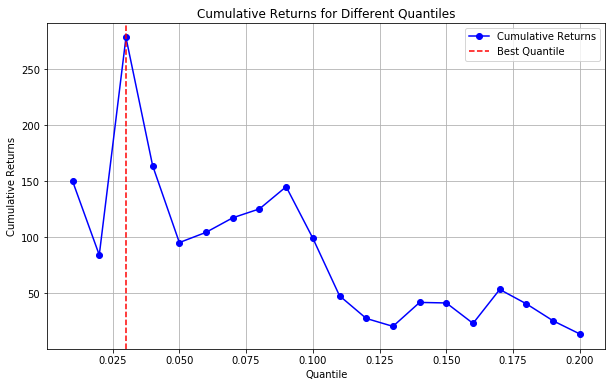

Best quantile to use: 0.03


In [234]:
# Find the quantile with the maximum cumulative returns
max_return = results_df['Cumulative_Returns'].max()
best_quantile = results_df.loc[results_df['Cumulative_Returns'] == max_return].index[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['Cumulative_Returns'], marker='o', linestyle='-', color='blue', label='Cumulative Returns')
plt.axvline(x=best_quantile, color='red', linestyle='--', label='Best Quantile')

# Customize the plot
plt.title('Cumulative Returns for Different Quantiles')
plt.xlabel('Quantile')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

print(f"Best quantile to use: {best_quantile}")

## Comparison to his data
Data import has been done above in the introduction.

In [225]:
# modify the dataframe
SLOPE_given = SLOPE_given[['Date', 'PC2']]

# Rename 'PC2' to 'Slope'
SLOPE_given = SLOPE_given.rename(columns={'PC2': 'Slope'})
#SLOPE_given

Date    Slope
0     1996-01-04 -0.88016
1     1996-01-05 -0.83101
2     1996-01-08 -0.85582
3     1996-01-09 -1.05163
4     1996-01-10 -1.03497
...          ...      ...
5907  2019-06-24 -0.32745
5908  2019-06-25 -0.36115
5909  2019-06-26 -0.35134
5910  2019-06-27 -0.39096
5911  2019-06-28 -0.24251

[5912 rows x 2 columns]

In [226]:
# Initialize a list to hold the boolean values for each row
in_bottom_quintile = []

# Calculate quantile based on historical data up until date 't' for each observation
for i in range(len(SLOPE_given)):
    # Select the data up to the current row's date
    slope_data = SLOPE_given.loc[SLOPE_given['Date'] <= SLOPE_given.iloc[i]['Date']]
    #print(i)
    #print("Slope: ",slope_data)
    current_value = slope_data.iloc[-1]['Slope']
    #print("Current value: ", current_value)
    historical_values = slope_data.iloc[:-2]['Slope']
    #print("Historical values: ", historical_values)
    quantile = historical_values.quantile(0.2)
    #print('Quantile: ', quantile)
    in_bottom_quintile.append(current_value <= quantile)
    #print(f"True/False_{i}: ", in_bottom_quintile)

# Assign the list to a new column 'InBottomQuintile'
SLOPE_given['InBottomQuintile'] = in_bottom_quintile

In [228]:
# check how many times the current value is in the bottom quintile
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = SLOPE_given['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.910352
True     0.089648
Name: InBottomQuintile, dtype: float64


In [227]:
# merge the datasets
SLOPE_given['Date'] = pd.to_datetime(SLOPE_given['Date'])
returns_long_short_30_2 = STRADDLE_RET_given[['Date', 'r_1^{straddle}', 'r_1^{short straddle}']]
returns_long_short_30_2 = returns_long_short_30_2.merge(SLOPE_given[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_2['InBottomQuintile'] = returns_long_short_30_2['InBottomQuintile'].shift(1)
returns_long_short_30_2['InBottomQuintile'][0] = False #set first value manually
#print(returns_long_short_30)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [229]:
# Condition: If the 'condition_column' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30_2.apply(lambda row: row['r_1^{straddle}'] if row['InBottomQuintile'] else row['r_1^{short straddle}'], axis=1)
# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30_2['cumulative_returns'] = cumulative_return
#returns_long_short_30

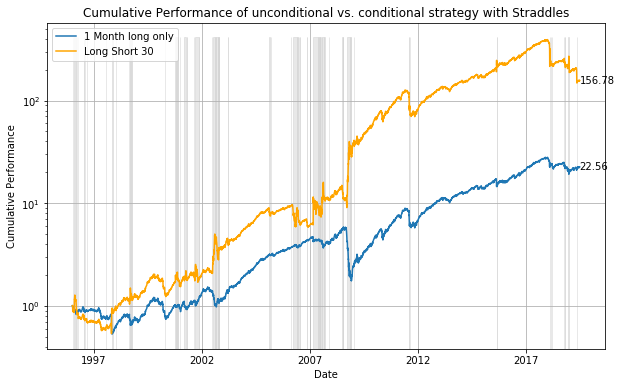

In [235]:
# Plotting the cumulative performances
#this is not finished yet and still needs some working!
plt.figure(figsize=(10, 6))

# Plot short only
plt.plot(STRADDLE_RET_given['Date'], STRADDLE_RET_given['cumulative_performance_1'], label=f'1 Month long only')
# Add text annotations for the end value of each line
end_value = STRADDLE_RET_given['cumulative_performance_1'].iloc[-1]
plt.text(STRADDLE_RET_given['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from the conditional strategy
plt.plot(returns_long_short_30_2['Date'], returns_long_short_30_2['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30_2['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30_2['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True
plt.fill_between(returns_long_short_30_2['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], 
                 where=returns_long_short_30_2['InBottomQuintile'], color='lightgrey', alpha=0.5)

years = pd.date_range(start='1996-01-05', end='2019-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional strategy with Straddles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

The differences differ a lot, even though the code that is applied is the exact same. This must be because of the differences in the data! Check how the returns look like with his PCA data.

In [251]:
# TEST: His PCA with our returns
#merge the datasets
SLOPE_given['Date'] = pd.to_datetime(SLOPE_given['Date'])
returns_long_short_30_3 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30_3 = returns_long_short_30_3.merge(SLOPE_given[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_3['InBottomQuintile'] = returns_long_short_30_3['InBottomQuintile'].shift(1)
returns_long_short_30_3['InBottomQuintile'][0] = False #set first value manually
# Condition: If the 'condition_column' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30_3.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)
# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30_3['cumulative_returns'] = cumulative_return

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


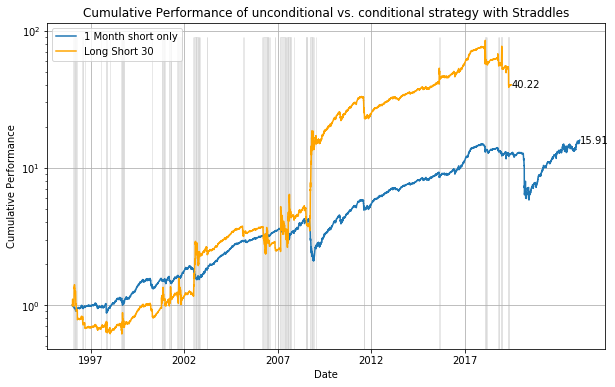

In [252]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))

# Plot unconditional strategy for the benchmark (coming from our data)
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from the conditional strategy
plt.plot(returns_long_short_30_3['Date'], returns_long_short_30_3['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30_3['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30_3['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True
plt.fill_between(returns_long_short_30_3['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], 
                 where=returns_long_short_30_3['InBottomQuintile'], color='lightgrey', alpha=0.5)

# some formatting
years = pd.date_range(start='1996-01-05', end='2019-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional strategy with Straddles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

# Option 2: Split the data in training and test data
Instead of getting the condition based on the expanding time window, we could also split the data into training and test sets. The training set is used to calculate the quintile. Then, the test data is comparing the current slope value to this quintile. If it is in the lower quintile, we take the long return, if it is not, we take the short return.

In [245]:
# Split the data into training and test sets
training_data = SLOPE[SLOPE['Date'] <= '2002-12-31'].copy()
test_data = SLOPE[SLOPE['Date'] > '2002-12-31'].copy()

# Calculate quantile based on historical distribution of the training data
quantile_train = training_data['Slope'].quantile(0.2)

# Assign the boolean values to the test data based on the calculated quantile
test_data['InBottomQuintile'] = test_data['Slope'].copy() <= quantile_train

In [246]:
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = test_data['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.918013
True     0.081987
Name: InBottomQuintile, dtype: float64


In [247]:
#merge the datasets
returns_long_short_30_4 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30_4 = returns_long_short_30_4.merge(test_data[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30_4['InBottomQuintile'] = returns_long_short_30_4['InBottomQuintile'].shift(1)
returns_long_short_30_4['InBottomQuintile'][0] = True #set first value manually

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [248]:
# Condition: If the 'condition_column' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30_4.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)
# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30_4['cumulative_returns'] = cumulative_return
#returns_long_short_30

In [249]:
# to be able to compare it to the short only strategy, we have to recalculate the short only cumulative returns
returns_short_test = returns_long_short_30_4[['Date', 'r_v_30']].copy()
returns_short_test['cumulative_performance'] = (1 + returns_short_test['r_v_30']).cumprod()

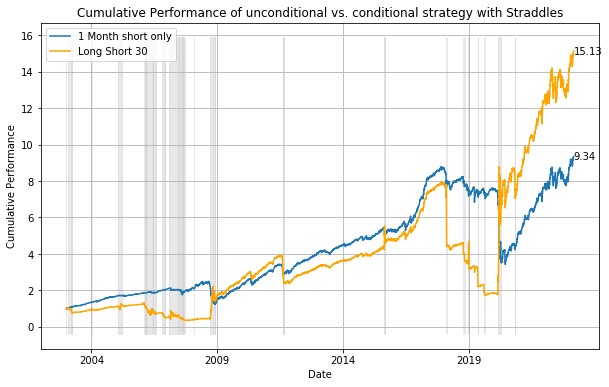

In [250]:
# Plotting the cumulative performances
#this is not finished yet and still needs some working!
plt.figure(figsize=(10, 6))

# Plot each line for different durations
plt.plot(returns_short_test['Date'], returns_short_test['cumulative_performance'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short_test['cumulative_performance'].iloc[-1]
plt.text(returns_short_test['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from 'returns_long_short_30'
plt.plot(returns_long_short_30_4['Date'], returns_long_short_30_4['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30_4['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30_4['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Shade the region where 'InBottomQuantile' is True
plt.fill_between(returns_long_short_30_4['Date'], plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], 
                 where=returns_long_short_30_4['InBottomQuintile'], color='lightgrey', alpha=0.5)

#STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'])
years = pd.date_range(start='2003-01-05', end='2022-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.title('Cumulative Performance of unconditional vs. conditional strategy with Straddles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

# Trying to find out why the results differ so much for the two PCA datasets

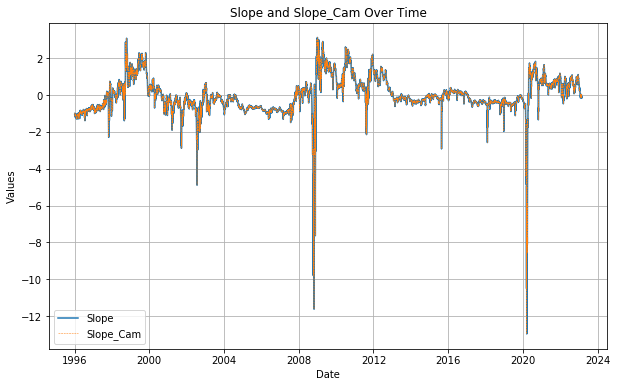

In [173]:
# File paths for the PCA slope data
file_path = 'Data/OUR_PCA.csv'

# Reading the CSV files into Pandas DataFrames and only store the column that is needed for the conditional strategy (Slope)
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Plotting
plt.figure(figsize=(10, 6))

# Plot 'Slope'
plt.plot(df['Date'], df['Slope'], label='Slope', linestyle = '-')

# Plot 'Slope_Cam'
plt.plot(df['Date'], df['Slope_Cam'], label='Slope_Cam', linestyle = '--', linewidth=0.5)

# Customize the plot
plt.title('Slope and Slope_Cam Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [181]:
print('Variance Cam: ', df['Slope_Cam'].var())
print('Variance Julius: ', df['Slope'].var())
print('Mean Cam: ', df['Slope_Cam'].mean())
print('Mean Julius: ', df['Slope'].mean())
print('Quantiles Julius: ', df['Slope'].quantile([0.2, 0.4, 0.6, 0.8]))
print('Quantiles Cam: ', df['Slope_Cam'].quantile([0.2, 0.4, 0.6, 0.8]))
print('Correlation: ', df['Slope'].corr(df['Slope_Cam']))

Variance Cam:  1.0001463271600946
Variance Julius:  1.0001463271543092
Mean Cam:  4.2075190523424754e-12
Mean Julius:  1.1558444870161423e-11
Quantiles Julius:  0.2   -0.645490
0.4   -0.300520
0.6    0.062660
0.8    0.690226
Name: Slope, dtype: float64
Quantiles Cam:  0.2   -0.645490
0.4   -0.300520
0.6    0.062660
0.8    0.690226
Name: Slope_Cam, dtype: float64
Correlation:  1.0


In [266]:
max_value = returns_long_short_30_3['return_30'].max()
best_row = returns_long_short_30_3.loc[returns_long_short_30_3['return_30'] == max_value]
print(best_row)
print(returns_long_short_30_3['r_v_30'].max())

print(returns_long_short_30_1['return_30'].max())
print(returns_long_short_30_1['r_v_30'].max())

max_value = returns_long_short_30_2['r_1^{straddle}'].max()
best_row = returns_long_short_30_2.loc[returns_long_short_30_2['r_1^{straddle}'] == max_value]
print(best_row)
print(returns_long_short_30_2['r_1^{short straddle}'].max())

           Date  return_30    r_v_30 InBottomQuintile  cumulative_returns
2801 2007-02-27   1.114533 -0.060919             True            5.219878
0.10137562274775323
1.114532762638977
0.1094327204732478
           Date  r_1^{straddle}  r_1^{short straddle} InBottomQuintile  \
2804 2007-02-27         0.86382              -0.10319             True   

      cumulative_returns  
2804           11.506878  
0.08977
